# Qualtrics: Guide for Data Extraction and Analysis in Clinical Research

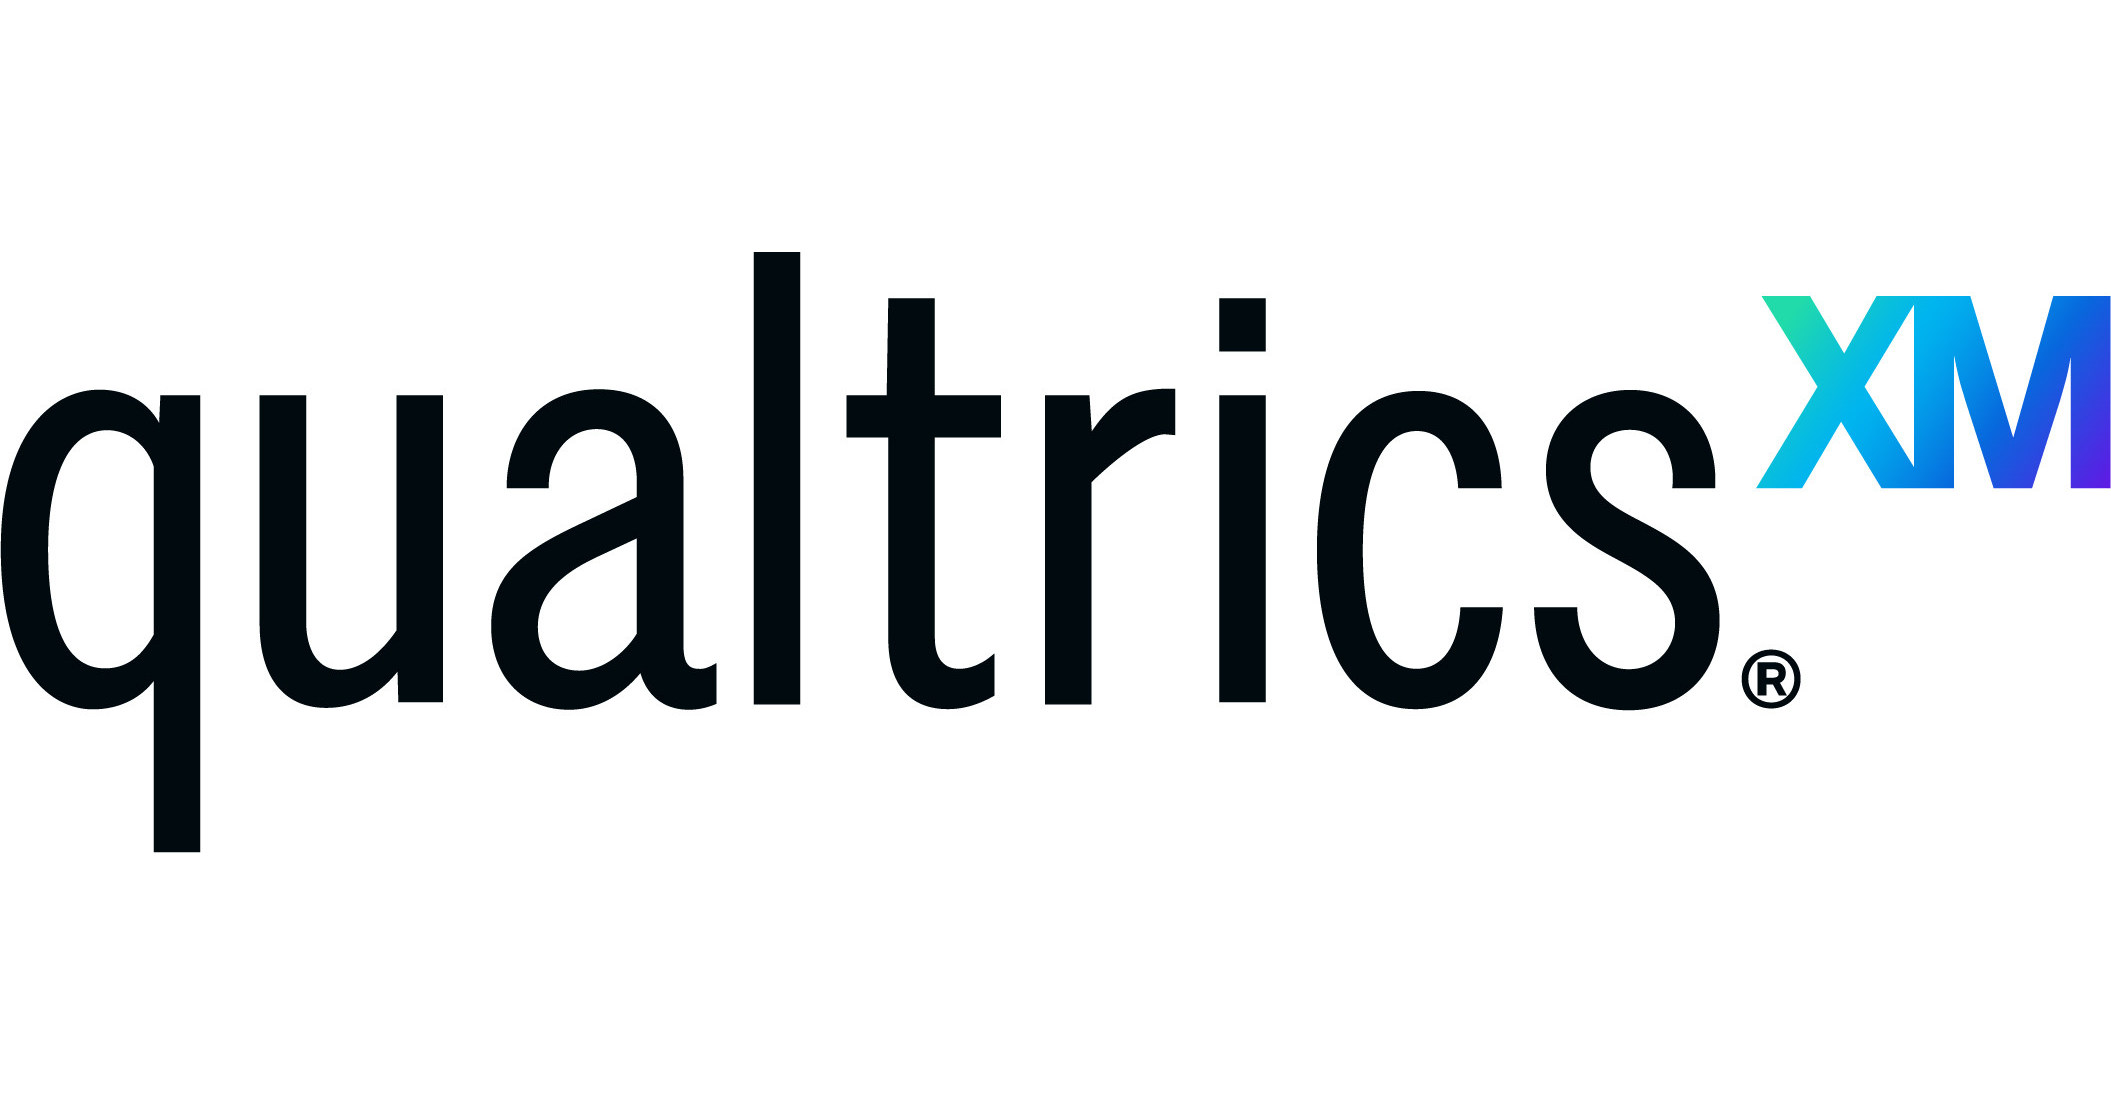

*Pictured: Qualtrics Logo*


[Qualtrics](https://www.qualtrics.com/) is a HIPAA-compliant online survey platform that allows healthcare providers to create, distribute, and analyze customizable questionnaires for collecting patient information. Qualtrics is commonly used in clinical research and patient feedback collection, ensuring efficient and compliant data management in healthcare settings. Qualtrics can generally be accessed through your institution.

If you want to learn more about Qualtrics, see the [Getting Started Guide](https://www.qualtrics.com/support/survey-platform/getting-started/survey-platform-overview/) for an overview of its key features. More information about the data Qualtrics collects can be found in [Qualtrics' official API documentation](https://api.qualtrics.com/).

[Wearipedia](https://www.wearipedia.com/) simplifies the data extraction process from surveys created on Qualtrics. We will import and use the ```wearipedia``` package here to extract the questions and answers we receive from our sample patient intake questionnaire.

This notebooks covers the following nine topics:

1. **Set Up**
  - We cover setting up Qualtrics so that we can extract data from out patient questionnaire.
2. **Authentication and Authorization**
  - We go over how to authenticate access to data.
3. **Data Extraction**
  - We extract data using ```wearipedia```, our open-source Python package that unifies dozens of complex wearable or questionnaire APIs into one simple, common interface.
  - We fetch some data that has been artifically generated so that we can gain some fun insights into the data.
4. **Data Exporting**
  - We export the data to JSON, CSV, and XLSX formats, all of which are compatible with popular scientific computing software and prompting large language models.
5. **Further Processing**
  - We filter out any incomplete survey responses.
  - We score our patient questionnaire based on an established clinical indices.
6. **Visualization**
  - We begin our visual analysis by exploring the distribution of PHQ-9 and GAD-7 severity levels using bar charts.
  - These plots give us a high-level overview of how respondents are distributed across mental health severity categories.
7. **Advanced Visualization**
  - To uncover the relationship between depression and anxiety levels, we use a Parallel Categories Plot (Alluvial Flow) and a Stacked Bar Chart.
  - These visualizations allow us to see how respondents move across PHQ-9 and GAD-7 severity buckets.
8. **Outlier Detection**
  - Using an Isolation Forest, we identify respondents whose item-level answer patterns are statistically unusual in the 16-dimensional survey space. These outliers are projected into 2D using t-SNE.
9. **Qualitative Analysis of Natural Language**
  - Our survey contains open-ended responses from participants.
  - We analyze themes in these natural language comments to see the importance of integrating both structured and unstructured data in mental health analysis.

**Disclaimer:** This notebook has been created purely for educational purposes. All of the data currently stored in this notebook is purely synthetic, meaning the data was randomly generated according to our internal algorithms. Because the end-to-end data extraction pipeline has been tested, feel free to enter your own authorization credentials and use our notebook as a starting point. The Wearipedia API package is a work in progress, so we would appreciate it if you notify us of any bugs, missing extraction features, or incorrect information.

# 1. Set Up

## Study Participant Setup and Usage

### Partipant Setup

There is not much setup that needs to be done by the participant. You should simply make sure that the participant has the correct link to your Qualtrics questionnaire. Ask the participant to access that link and fill out the survey as completely and accurately as possible.

### Data Receiver Setup

You should follow the following steps:
1. Get access to Qualtrics through your institution and follow its instructions for onboarding.

2. Once you have access to Qualtrics, create the survey you want to distribute. Here's the [official guide](https://www.qualtrics.com/support/getting-started-qualtrics/learn-the-xm-platform/) on navigating the Qualtrics platform.

3. Distribute the public survey link to the participant and instruct them to complete the questionnaire.

5. Install the ```wearipedia``` Python package to easily extract data from your Qualtrics survey.

In [32]:
!pip install --no-cache-dir git+https://github.com/cheejung/wearipedia.git

  Cloning https://github.com/cheejung/wearipedia.git to /tmp/pip-req-build-xq439047
  Running command git clone --filter=blob:none --quiet https://github.com/cheejung/wearipedia.git /tmp/pip-req-build-xq439047
  Resolved https://github.com/cheejung/wearipedia.git to commit 26a68168fe53d4e5b58a98c1b068893acdef1e29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openai to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 11.8 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtrack

# 2. Authentication and Authorization

To obtain access to data, we need to obtain three key pieces of information: your ```survey_id```, ```data_center ```, and ```token```.

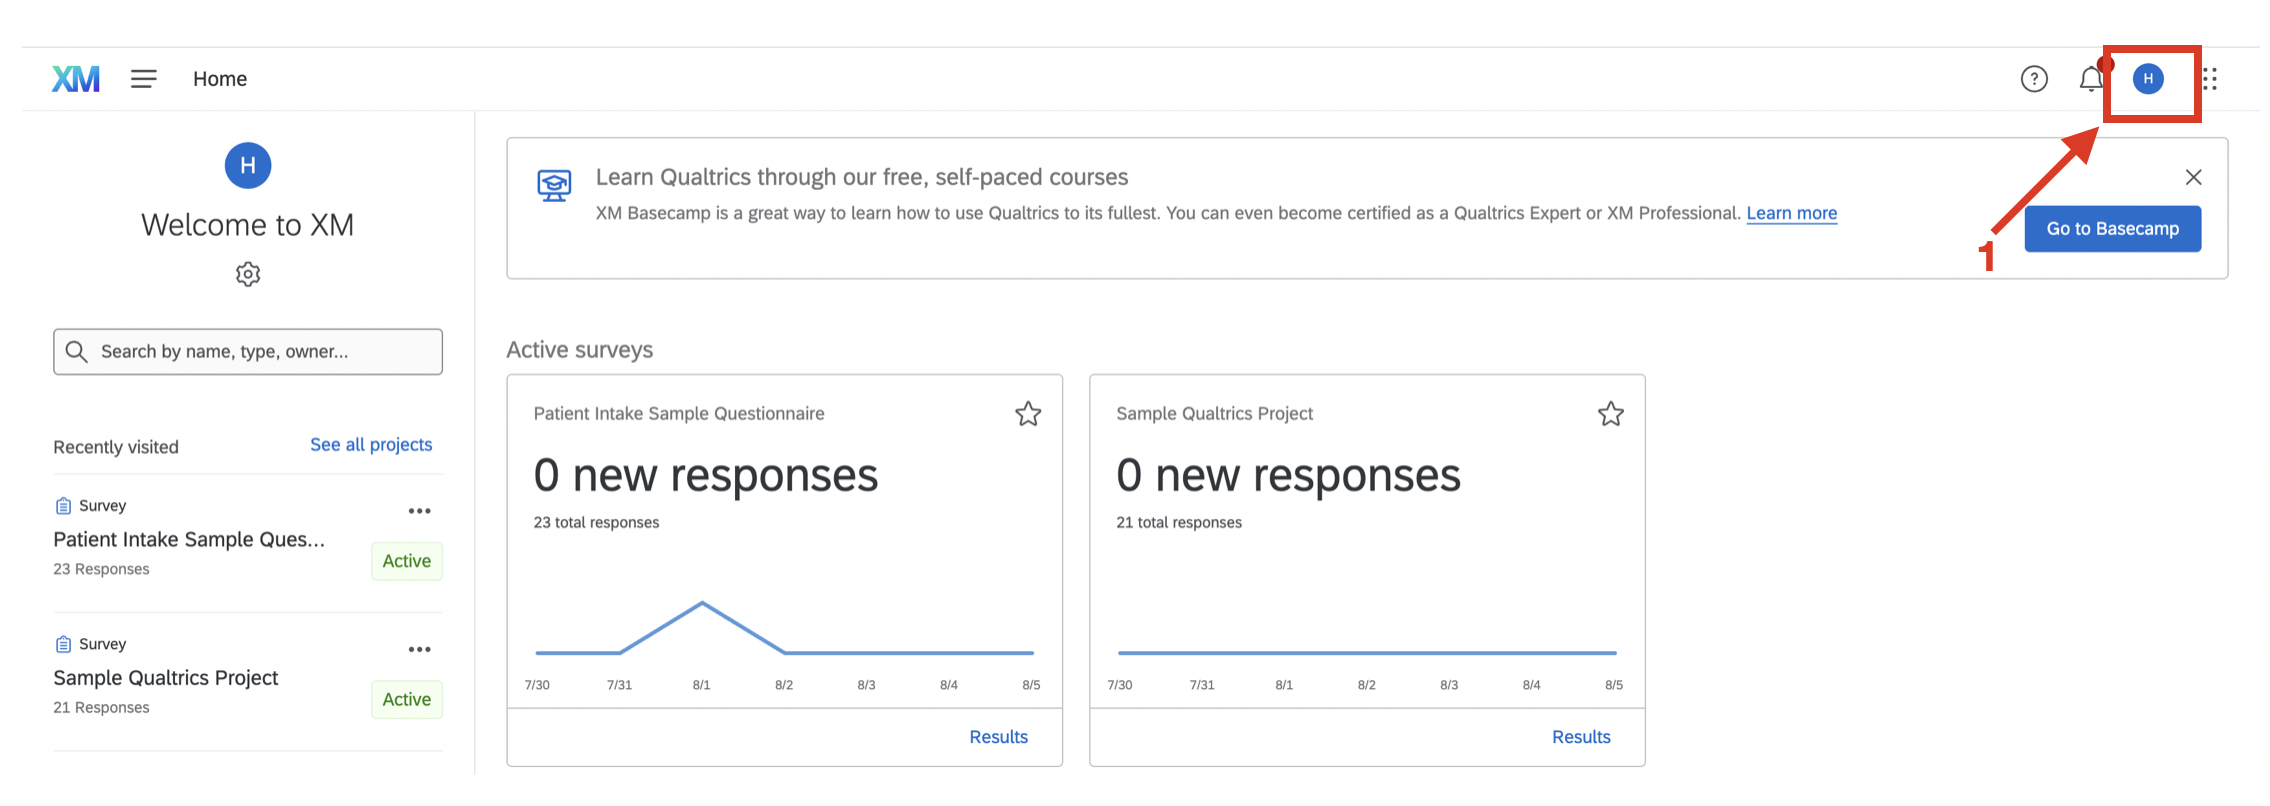

Once you are logged in, press on your profile icon in the upper right corner.

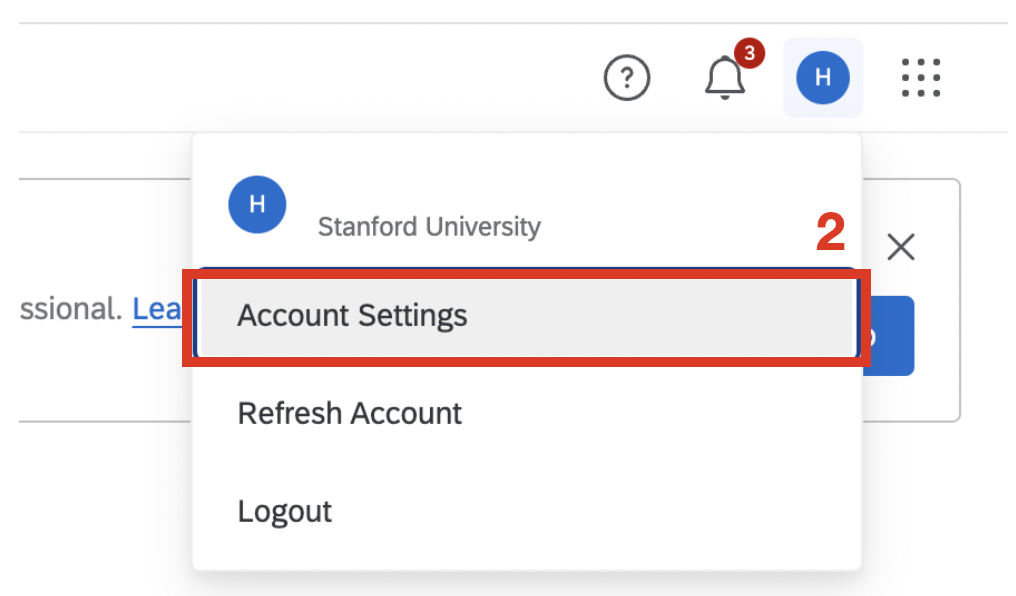

Then, click on "Account Settings."

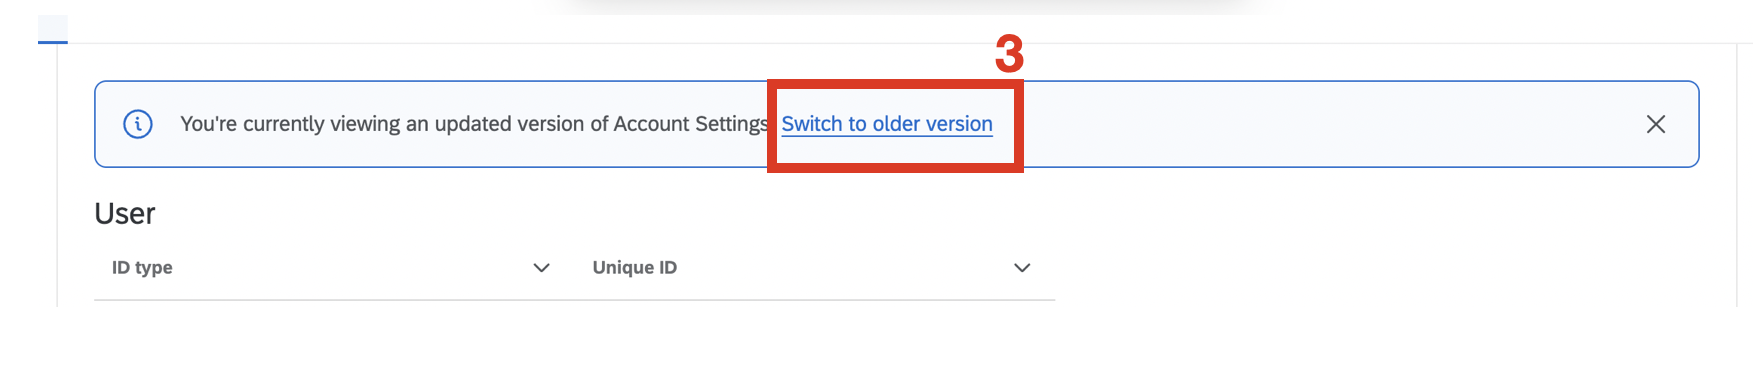

At the top, you will see a blue banner. Click on "Switch to older version."

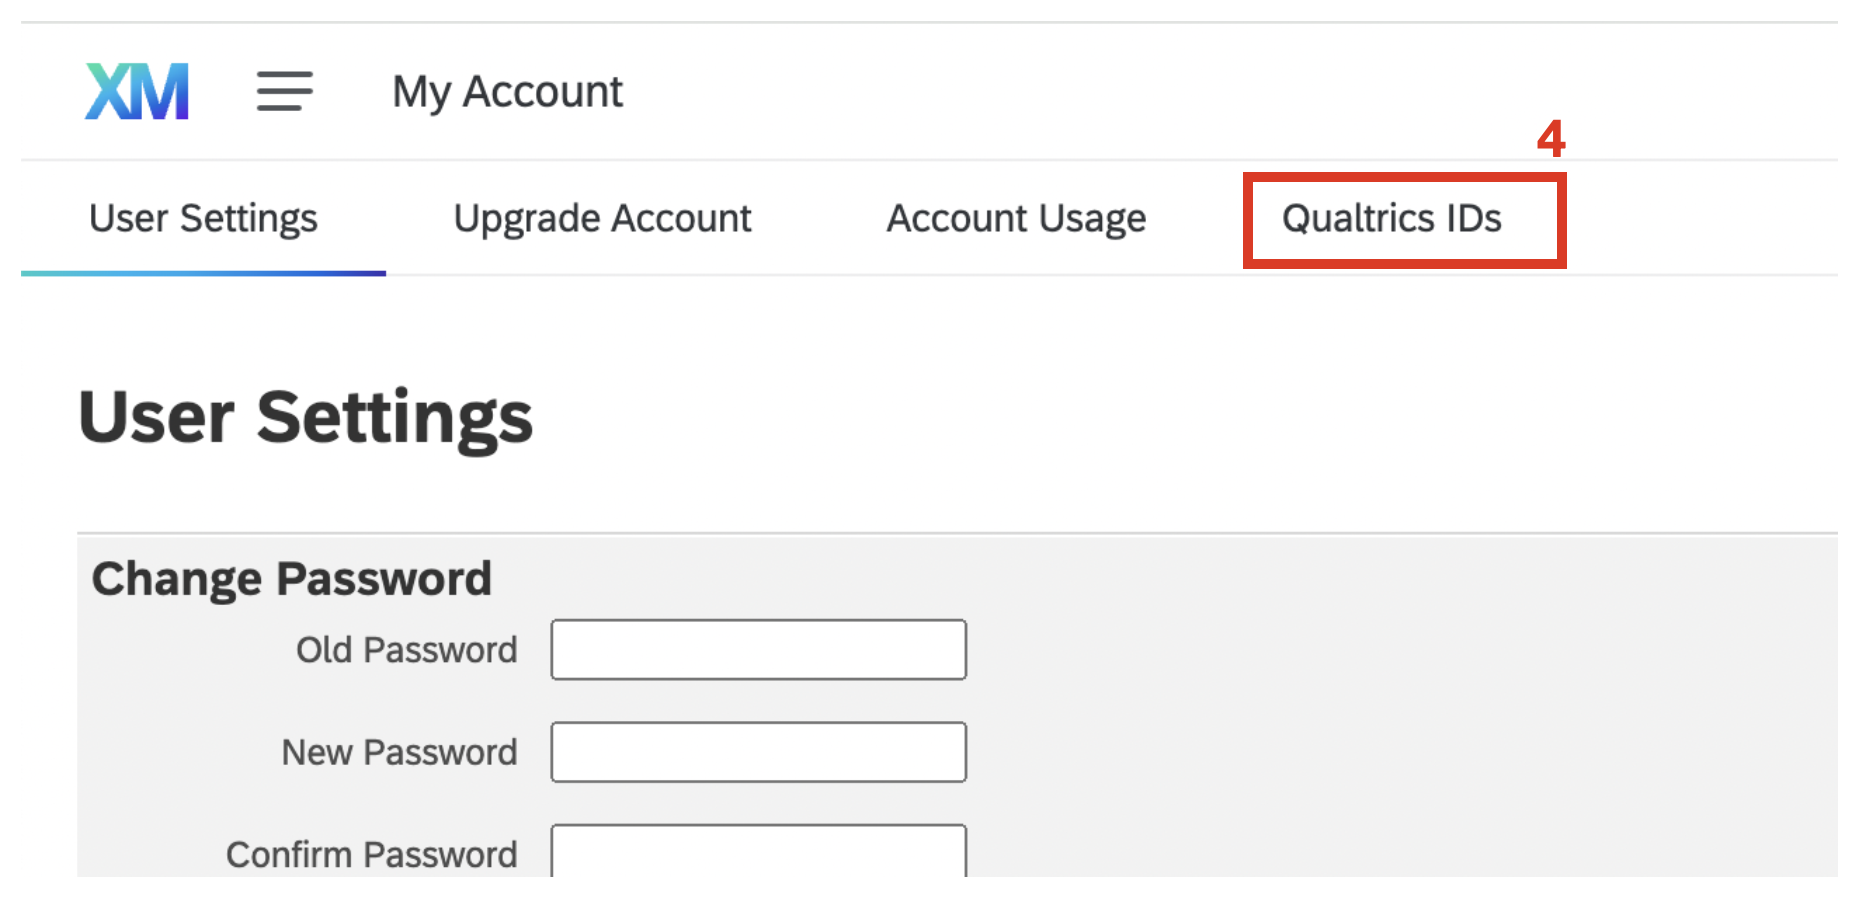

Click on "Qualtrics IDs."

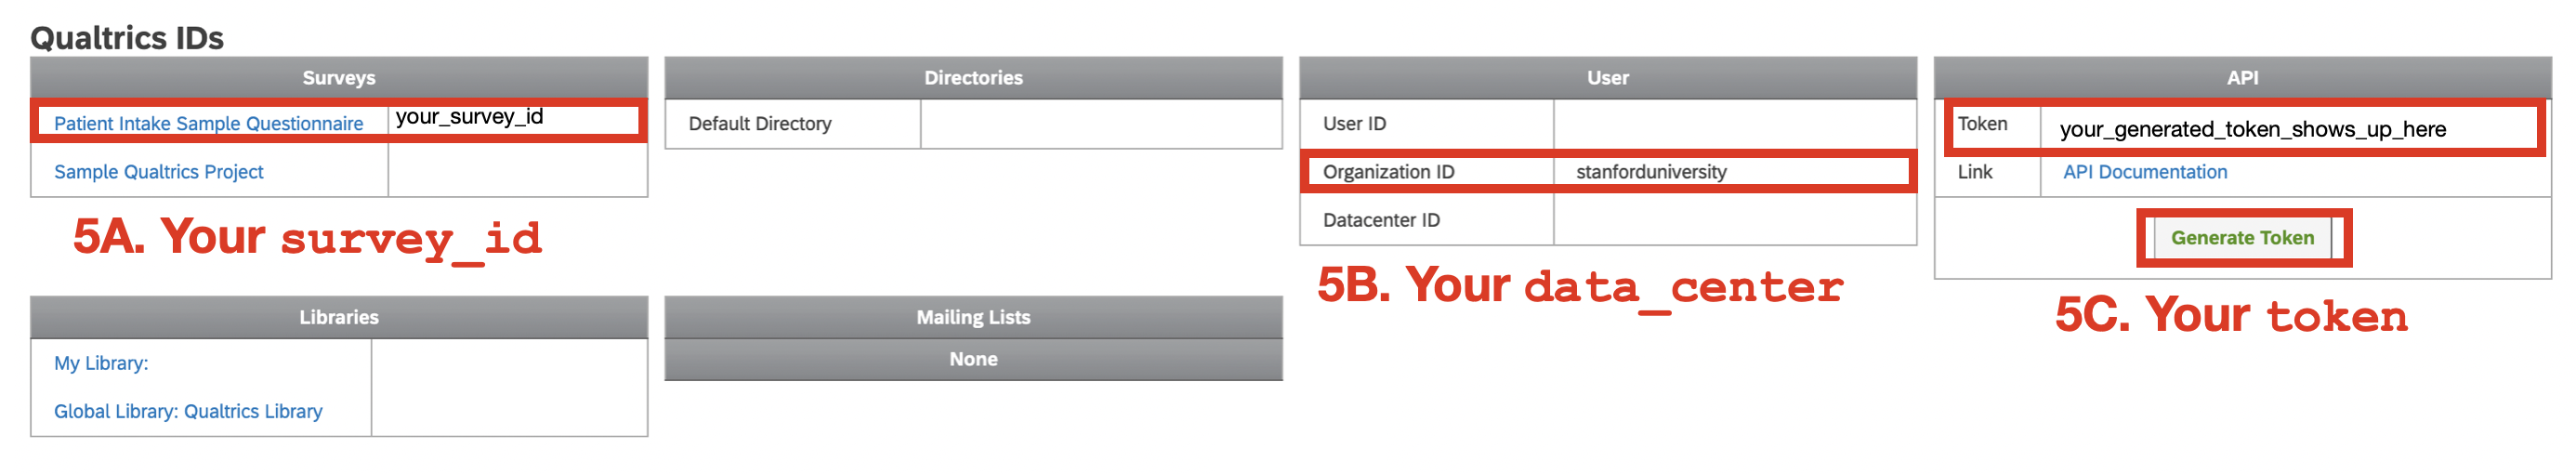

You want to take note three key pieces of information.

1. ```survey_id```: In the "Surveys" box, find the ```survey_id``` of the **survey you want to import**.
2. ```data_center```: This can be found in the "User" box. This will listed right next to "Organization ID." **Do not confuse this with "Datacenter ID."**
3. ``token``: You should click on "Generate Token." Then, copy down the ```token``` that is generated.

If you prefer to work with your own survey, complete the following information below. If you'd rather play with our synthetic survey, feel free to leave this part blank and set ```synthetic``` to ```True```.

## Get API Access

In [4]:
survey_id = 'your_survey_ud'  #@param {type:"string"}
data_center = 'your_data_center'  #@param {type:"string"}
token = 'your_token'  #@param {type:"string"}

# 3. Data Extraction

We will extract data using ```wearipedia```, our open-source Python package that simplifies the integration of complex device APIs into a single, common interface.

You have the option to extract real data from your questionnaire or choose "synthetic" to see sample data generated from Wearipedia's patient intake questionnaire. For this analysis, we will use synthetic data.

## What does Wearipedia's patient intake questionnaire include?

It simulates a typical clinical patient intake process. The questionnaire begins by asking for the patient's name and date of birth, allowing this information to be linked with other records in the patient's electronic health record. It then includes questions from the PHQ-9 and GAD-7 assessments. Finally, the user is prompted with a free response section where they can discuss any concerns affecting the patient.

Survey link: https://stanforduniversity.qualtrics.com/jfe/form/SV_cvdwsmdifePJNsi

In [5]:
import wearipedia

synthetic = True  #@param {type:"boolean"}

device = wearipedia.get_device("qualtrics/qualtrics")

if not synthetic:
    device.authenticate({"token": token, "data_center": data_center})

params = {"survey": survey_id}

responses = device.get_data("responses", params=params)

Some users may encounter the following error when importing ```wearipedia``` (due to a NumPy upgrade):

```ValueError: numpy.dtype size changed, may indicate binary incompatibility```

If this happens, run the cell below, and then the re-run the notebook from the top. Don't run this cell below again.

In [ ]:
# Downgrade numpy to a stable version that avoids ABI issues
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir
import os
os.kill(os.getpid(), 9)  # Restart runtime

# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software, such as R, Excel, and MATLAB. Note that our ```wearipedia``` responses are conveniently returned as Pandas DataFrames.

## Export to JSON

In [6]:
import json

data = {'responses': responses.to_dict(orient='records')}

json.dump(data, open("responses.json", "w"))

## Export to CSV

In [8]:
responses.to_csv("responses.csv", index=False)

## Export to XLSX

In [9]:
import pandas as pd

with pd.ExcelWriter('responses.xlsx') as writer:
    responses.to_excel(writer, sheet_name='responses', index=False)

# 5. Further Processing

## Adherance

In many cases, patients might start a survey but not finish it. Let's first make sure that none of that's included in our analysis. Luckily, our API contains a ```Finished``` column that makes the detection of incomplete responses easy.

Let's first take a quick look at the first couple rows of the responses.

In [10]:
responses.head()

StartDate  \
0                               Start Date   
1  {"ImportId":"startDate","timeZone":"Z"}   
2                      2024-08-15 03:03:10   
3                      2024-08-15 03:07:14   
4                      2024-08-15 03:08:20   

                                 EndDate                 Status  \
0                               End Date          Response Type   
1  {"ImportId":"endDate","timeZone":"Z"}  {"ImportId":"status"}   
2                    2024-08-15 03:04:52         Survey Preview   
3                    2024-08-15 03:08:14         Survey Preview   
4                    2024-08-15 03:09:25         Survey Preview   

                  IPAddress                 Progress    Duration (in seconds)  \
0                IP Address                 Progress    Duration (in seconds)   
1  {"ImportId":"ipAddress"}  {"ImportId":"progress"}  {"ImportId":"duration"}   
2                       NaN                      100                      101   
3                       NaN                      100                       59   
4                       NaN                      100                       64   

                  Finished                                RecordedDate  \
0                 Finished                               Recorded Date   
1  {"ImportId":"finished"}  {"ImportId":"recordedDate","timeZone":"Z"}   
2                     True                         2024-08-15 03:04:52   
3                     True                         2024-08-15 03:08:14   
4                     True                         2024-08-15 03:09:25   

                 ResponseId                 RecipientLastName  ...  \
0               Response ID               Recipient Last Name  ...   
1  {"ImportId":"_recordId"}  {"ImportId":"recipientLastName"}  ...   
2         R_7l6ochnzHTcEZbj                               NaN  ...   
3         R_71hZi1jox9IZGlL                               NaN  ...   
4         R_7yefcEdN5mVMDSB                               NaN  ...   

                                           PHQ-9_Add  \
0  4a. How difficult have these problems made it ...   
1                                {"ImportId":"QID1"}   
2                                 Somewhat difficult   
3                                     Very difficult   
4                                 Somewhat difficult   

                                             GAD-7_1  \
0  GAD-7\n\n5. Over the last 2 weeks, how often h...   
1                             {"ImportId":"QID27_1"}   
2                            More than half the days   
3                            More than half the days   
4                                   Nearly every day   

                                             GAD-7_2  \
0  GAD-7\n\n5. Over the last 2 weeks, how often h...   
1                             {"ImportId":"QID27_2"}   
2                            More than half the days   
3                            More than half the days   
4                                   Nearly every day   

                                             GAD-7_3  \
0  GAD-7\n\n5. Over the last 2 weeks, how often h...   
1                             {"ImportId":"QID27_3"}   
2                                       Several days   
3                            More than half the days   
4                                   Nearly every day   

                                             GAD-7_4  \
0  GAD-7\n\n5. Over the last 2 weeks, how often h...   
1                             {"ImportId":"QID27_4"}   
2                                   Nearly every day   
3                            More than half the days   
4                                   Nearly every day   

                                             GAD-7_5  \
0  GAD-7\n\n5. Over the last 2 weeks, how often h...   
1                             {"ImportId":"QID27_5"}   
2                            More than half the days   
3                            More than half the days   
4                                  

In [11]:
filtered_df = responses[responses['Finished'] == "False"]
filtered_df

Empty DataFrame
Columns: [StartDate, EndDate, Status, IPAddress, Progress, Duration (in seconds), Finished, RecordedDate, ResponseId, RecipientLastName, RecipientFirstName, RecipientEmail, ExternalReference, LocationLatitude, LocationLongitude, DistributionChannel, UserLanguage, F_Name, L_Name, DOB#1_1, DOB#2_1, DOB#3_1, PHQ-9_1, PHQ-9_2, PHQ-9_3, PHQ-9_4, PHQ-9_5, PHQ-9_6, PHQ-9_7, PHQ-9_8, PHQ-9_9, PHQ-9_Add, GAD-7_1, GAD-7_2, GAD-7_3, GAD-7_4, GAD-7_5, GAD-7_6, GAD-7_7, GAD-7_Add, Add_Info]
Index: []

[0 rows x 41 columns]

Great. We only have complete responses. In fact, you can set your Qualtrics survey so that only complete responses will be recorded.

## Scoring

The natural language responses in the survey columns now need to be mapped to numerical scores for both PHQ-9 and GAD-7. After calculating the total score for both assessments, we will classify each score into a bucket that indicates the severity level. We'll do this in the following manner:

1. **Map Natural Language Responses to Numerical Scores:**
   - **Not at all** → 0 points
   - **Several days** → 1 point
   - **More than half the days** → 2 points
   - **Nearly every day** → 3 points

2. **Calculate Total Scores for PHQ-9 and GAD-7:**
    - For each row, the score is the sum of numerical values from each of the following columns, which represent a question. There are total of nine questions in the PHQ-9 and seven questions for the GAD-7.

3. **Assign Severity Buckets Based on the Total Scores:** The total score is used to assign a severity bucket, according to the following tables.

### PHQ-9 Severity Buckets

| Score Range | Severity Level      |
|-------------|---------------------|
| 0 - 4       | None-minimal         |
| 5 - 9       | Mild                 |
| 10 - 14     | Moderate             |
| 15 - 19     | Moderately severe    |
| 20 - 27     | Severe               |

### GAD-7 Severity Buckets

| Score Range | Severity Level      |
|-------------|---------------------|
| 0 - 4       | None-minimal         |
| 5 - 9       | Mild                 |
| 10 - 14     | Moderate             |
| 15 - 21     | Severe               |

In [12]:
# Define the mapping from responses to numerical scores
response_mapping = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

def calculate_phq9_score(row):
    phq9_columns = ['PHQ-9_1', 'PHQ-9_2', 'PHQ-9_3', 'PHQ-9_4', 'PHQ-9_5', 'PHQ-9_6', 'PHQ-9_7', 'PHQ-9_8', 'PHQ-9_9']
    score = sum(response_mapping.get(row[col], 0) for col in phq9_columns)
    if score <= 4:
        return score, 'None-minimal'
    elif score <= 9:
        return score, 'Mild'
    elif score <= 14:
        return score, 'Moderate'
    elif score <= 19:
        return score, 'Moderately severe'
    else:
        return score, 'Severe'

def calculate_gad7_score(row):
    gad7_columns = ['GAD-7_1', 'GAD-7_2', 'GAD-7_3', 'GAD-7_4', 'GAD-7_5', 'GAD-7_6', 'GAD-7_7']
    score = sum(response_mapping.get(row[col], 0) for col in gad7_columns)
    if score <= 4:
        return score, 'None-minimal'
    elif score <= 9:
        return score, 'Mild'
    elif score <= 14:
        return score, 'Moderate'
    else:
        return score, 'Severe'

responses['PHQ-9_Score'], responses['PHQ-9_Bucket'] = zip(*responses.apply(calculate_phq9_score, axis=1))
responses['GAD-7_Score'], responses['GAD-7_Bucket'] = zip(*responses.apply(calculate_gad7_score, axis=1))

Now, let's filter responses where the PHQ-9 or GAD-7 interpretation is "Moderate" or higher.


In [13]:
severity_levels = ['Moderate', 'Moderately severe', 'Severe']

moderate_or_higher_responses = responses[
    (responses['PHQ-9_Bucket'].isin(severity_levels)) |
    (responses['GAD-7_Bucket'].isin(severity_levels))
]

moderate_or_higher_responses

StartDate              EndDate          Status IPAddress  \
2   2024-08-15 03:03:10  2024-08-15 03:04:52  Survey Preview       NaN   
3   2024-08-15 03:07:14  2024-08-15 03:08:14  Survey Preview       NaN   
4   2024-08-15 03:08:20  2024-08-15 03:09:25  Survey Preview       NaN   
5   2024-08-15 03:09:59  2024-08-15 03:17:38  Survey Preview       NaN   
6   2024-08-15 03:17:49  2024-08-15 03:19:41  Survey Preview       NaN   
7   2024-08-15 03:19:49  2024-08-15 03:21:44  Survey Preview       NaN   
8   2024-08-15 03:21:51  2024-08-15 03:27:03  Survey Preview       NaN   
9   2024-08-15 03:27:20  2024-08-15 03:28:19  Survey Preview       NaN   
10  2024-08-15 03:28:23  2024-08-15 03:29:31  Survey Preview       NaN   
11  2024-08-15 03:29:45  2024-08-15 03:32:44  Survey Preview       NaN   
12  2024-08-15 03:35:27  2024-08-15 03:37:12  Survey Preview       NaN   
13  2024-08-15 03:37:16  2024-08-15 03:39:03  Survey Preview       NaN   
14  2024-08-15 03:39:07  2024-08-15 03:40:42  Survey Preview       NaN   
15  2024-08-15 03:40:45  2024-08-15 03:42:09  Survey Preview       NaN   
16  2024-08-15 03:42:14  2024-08-15 03:44:31  Survey Preview       NaN   
19  2024-08-15 03:48:49  2024-08-15 03:50:17  Survey Preview       NaN   
20  2024-08-15 03:50:26  2024-08-15 03:51:46  Survey Preview       NaN   

   Progress Duration (in seconds) Finished         RecordedDate  \
2       100                   101     True  2024-08-15 03:04:52   
3       100                    59     True  2024-08-15 03:08:14   
4       100                    64     True  2024-08-15 03:09:25   
5       100                   458     True  2024-08-15 03:17:38   
6       100                   111     True  2024-08-15 03:19:42   
7       100                   115     True  2024-08-15 03:21:45   
8       100                   312     True  2024-08-15 03:27:04   
9       100                    59     True  2024-08-15 03:28:20   
10      100                    67     True  2024-08-15 03:29:31   
11      100                   178     True  2024-08-15 03:32:45   
12      100                   105     True  2024-08-15 03:37:13   
13      100                   106     True  2024-08-15 03:39:03   
14      100                    95     True  2024-08-15 03:40:42   
15      100                    83     True  2024-08-15 03:42:09   
16      100                   136     True  2024-08-15 03:44:31   
19      100                    88     True  2024-08-15 03:50:18   
20      100                    79     True  2024-08-15 03:51:46   

           ResponseId RecipientLastName  ...                  GAD-7_4  \
2   R_7l6ochnzHTcEZbj               NaN  ...         Nearly every day   
3   R_71hZi1jox9IZGlL               NaN  ...  More than half the days   
4   R_7yefcEdN5mVMDSB               NaN  ...         Nearly every day   
5   R_72mVA69AsT1F7GV               NaN  ...  More than half the days   
6   R_7EhYg3iglUgedFA               NaN  ...         Nearly every day   
7   R_7OpEs8mpvSzExVa               NaN  ...         Nearly every day   
8   R_7EmWYALrPuBfv8F               NaN  ...  More than half the days   
9   R_7tc0HJB7suisDkt               NaN  ...             Several days   
10  R_7Pi0ivpc2CQBwlk               NaN  ...         Nearly every day   
11  R_7YmiI28KKqOCoh5               NaN  ...  More than half the days   
12  R_7k0W6GBkyzjulpr               NaN  ...  More than half the days   
13  R_7Kl762qhTk7MdcF               NaN  ...         Nearly every day   
14  R_7QDUWDTBwr9T7iq               NaN  ...  More than half the days   
15  R_7usnR9nta5SY8LL               NaN  ...         Nearly every day   
16  R_7S2ngSpFQLvsyye               NaN  ...  More than half the days   
19  R_7gQxYQZ4z1mrdlv               NaN  ...         Nearly every day   
20  R_7qfvcCDoLaUTrQd               NaN  ...             Several days   

                    GAD-7_5                  GAD-7_6                  GAD-7_7  \
2   More than half the days  More than half the days         Nearly every day 

It seems like we have 17 patients who might need special attention.

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our responses. Specifically, we're analyzing PHQ-9 and GAD-7 survey responses to quantify levels of depression and anxiety among participants. By converting qualitative answers into numerical scores and categorizing severity levels, we can visualize mental health trends across the group. This helps identify at-risk individuals and informs targeted interventions or follow-up support.

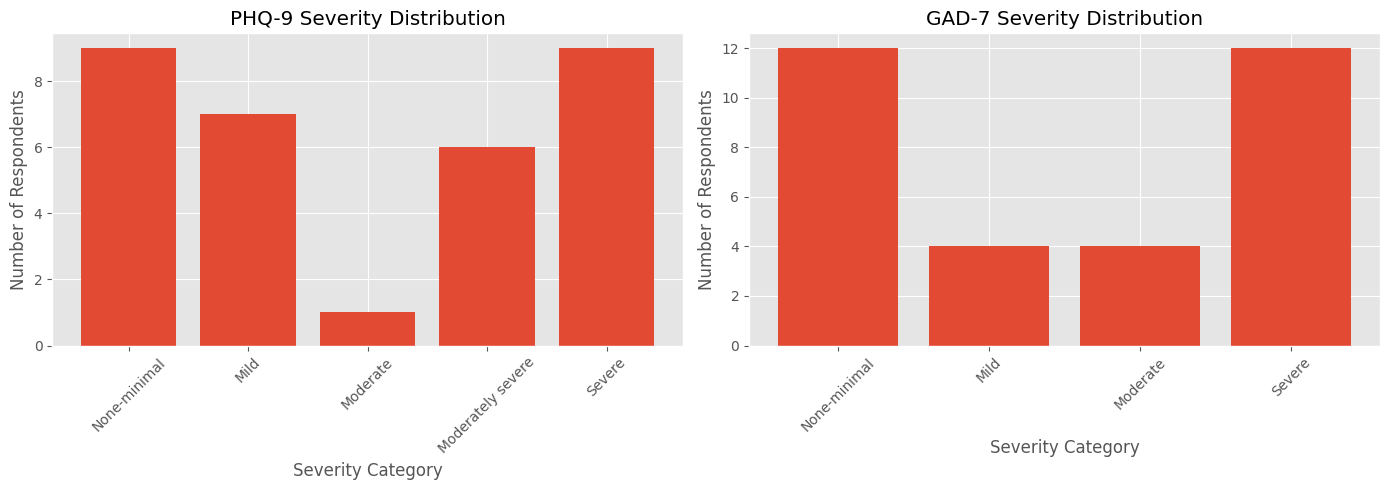

In [17]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot PHQ-9 Severity Bucket counts
phq9_counts = responses['PHQ-9_Bucket'].value_counts().reindex(
    ['None-minimal', 'Mild', 'Moderate', 'Moderately severe', 'Severe']
)
axes[0].bar(phq9_counts.index, phq9_counts.values)
axes[0].set_title("PHQ-9 Severity Distribution")
axes[0].set_ylabel("Number of Respondents")
axes[0].set_xlabel("Severity Category")
axes[0].tick_params(axis='x', rotation=45)

# Plot GAD-7 Severity Bucket counts
gad7_counts = responses['GAD-7_Bucket'].value_counts().reindex(
    ['None-minimal', 'Mild', 'Moderate', 'Severe']
)
axes[1].bar(gad7_counts.index, gad7_counts.values)
axes[1].set_title("GAD-7 Severity Distribution")
axes[1].set_ylabel("Number of Respondents")
axes[1].set_xlabel("Severity Category")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The plots show a noticeable concentration of respondents in the “Moderately severe” and “Severe” categories for both PHQ-9 and GAD-7, indicating a high prevalence of significant depression and anxiety symptoms. This suggests that a substantial portion of the surveyed population may be experiencing serious mental health challenges, warranting further attention or intervention.

A very reasonable explanation is that our synthetic survey may have been distributed during or after a period of heightened stress. For the purposes of this notebook, let's asssume an imaginary pandemic has taken place.

# 7. Advanced Visualization

Qualtrics often is able to create more interesting plots, and you're encouraged to make use of Qualtrics' advanced data visualization features to create cool plots. Most customizable plots can also be made using Python.

## 7.1. Parallel Categories Plot (Alluvial Flow)

The is type of plot shows the flows from PHQ-9 buckets to GAD-7 buckets, meaning that we can see how people “flow” between depression and anxiety levels

In [18]:
import plotly.express as px

fig = px.parallel_categories(
    responses,
    dimensions=['PHQ-9_Bucket', 'GAD-7_Bucket'],
    color=responses['PHQ-9_Score'].astype(int),
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={
        'PHQ-9_Bucket': 'Depression Level',
        'GAD-7_Bucket': 'Anxiety Level'
    },
    title="PHQ-9 and GAD-7 Severity Flow"
)

fig.show()

Thicker bands clearly show strong overlaps. For instance, many people in the “Severe” PHQ-9 category also fall into “Severe” GAD-7. Some “None-minimal” depression respondents still report Moderate or Severe anxiety — showing discordance worth exploring.

## 7.2. Stacked Bar Chart: Combined PHQ-9 & GAD-7 Severity

Now, let's make a stacked bar chart showing the joint distribution of PHQ-9 (depression) and GAD-7 (anxiety) severity levels!

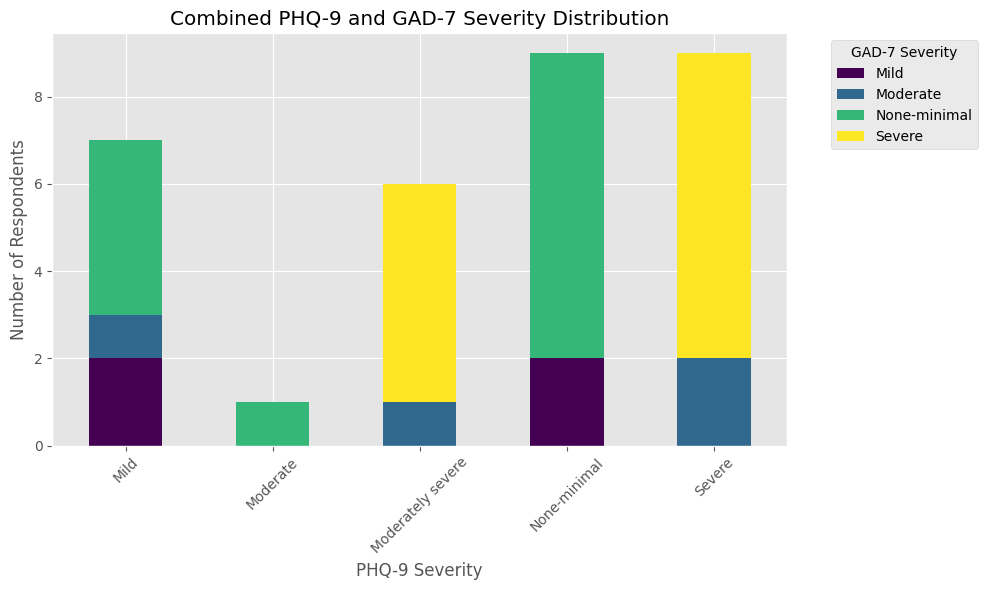

In [33]:
# Create a contingency table of PHQ-9 vs GAD-7 bucket combinations
combined_counts = responses.groupby(['PHQ-9_Bucket', 'GAD-7_Bucket']).size().unstack(fill_value=0)

ax = combined_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

ax.set_title("Combined PHQ-9 and GAD-7 Severity Distribution")
ax.set_xlabel("PHQ-9 Severity")
ax.set_ylabel("Number of Respondents")
ax.legend(title="GAD-7 Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

This chart makes it immediately apparent that individuals with Severe PHQ-9 scores also frequently report Severe GAD-7 symptoms, highlighting the co-occurrence of depression and anxiety. Interestingly, even in the None-minimal and Mild PHQ-9 categories, there's notable variation in GAD-7 severity, suggesting that some individuals may struggle with anxiety even in the absence of high depressive symptoms.

# 8. Outlier Detection

Now, we aim to identify outliers in our dataset.

In surveys like PHQ-9 (depression) and GAD-7 (anxiety), most people respond in predictable ways. But occasionally, someone answers in a way that doesn’t match the overall pattern---maybe due to unique mental health states, misunderstanding questions, or input errors.

We call these responses outliers. They matter because, clinically, they might represent people with complex symptom patterns. Statistically, they can distort averages and clustering.

## Step 1: Convert Categorical Responses to Numeric Vectors

Machine learning models operate in ℝⁿ (real-valued space). By converting categorical answers to ordinal scores, we can compute distances, variances, and run models like Isolation Forest or t-SNE.

In [43]:
phq9_cols = [f'PHQ-9_{i}' for i in range(1, 10)]
gad7_cols = [f'GAD-7_{i}' for i in range(1, 8)]
all_items = phq9_cols + gad7_cols

# Likert-style answers → integers (ordinal scale)
response_mapping = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

# Apply to the full dataset
score_df = responses[all_items].applymap(lambda x: response_mapping.get(x, None))
score_df_clean = score_df.dropna()  # Must remove missing data for math to work

## Step 2: Detect Statistically Unusual Patterns with Isolation Forest

Rare points tend to get isolated quickly in random partitions of space Isolation Forest randomly splits the dataset. Outliers tend to require fewer splits to isolate (i.e., they are "far" from other points in high dimensions). It doesn’t assume Gaussian distribution — making it ideal for skewed, real-world survey data.

Isolation Forest works on a simple idea:

> *Points that are rare or far from clusters get isolated faster when you randomly split the data.*

Let’s say we have these points on a line:

```

|----|----|----|----|----------------------------------------|
  1    2    3    4                    100

```

If we randomly choose a number between 1 and 100 to split the data (e.g., split at 10, split at 50, etc.), it will take many splits to isolate points like 3 and 4, because they are close together. But it only takes 1–2 splits to isolate 100 — it’s far from everything else!


In [47]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
iso_preds = iso.fit_predict(score_df_clean)

# Attach outlier flag
responses.loc[score_df_clean.index, 'Outlier_IForest'] = ['Outlier' if p == -1 else 'Normal' for p in iso_preds]

# Count summary
outlier_counts = responses['Outlier_IForest'].value_counts()
print("Isolation Forest Result:")
print(outlier_counts)

Isolation Forest Result:
Normal     27
Outlier     3
Name: Outlier_IForest, dtype: int64


## Step 3: Reduce Dimensions with t-SNE

We visualize structure by preserving local distances in high-dimensional data. Most data lives in high dimensions (e.g., 16 survey questions = ℝ¹⁶) t-SNE compresses that space to 2D, while trying to preserve local neighborhood distances. We can think of it like a map projection — it distorts some things, but preserves the shapes of clusters and gaps.

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embedding = tsne.fit_transform(score_df_clean)

# Store for later use
responses.loc[score_df_clean.index, 'tsne_x'] = embedding[:, 0]
responses.loc[score_df_clean.index, 'tsne_y'] = embedding[:, 1]

## Step 4: Visualize Outliers

The clusters represent people who answered similarly. Specifically, red points indicate that they are statistically isolated. Separation in the plot indicates different trajectories of mental health symptoms.

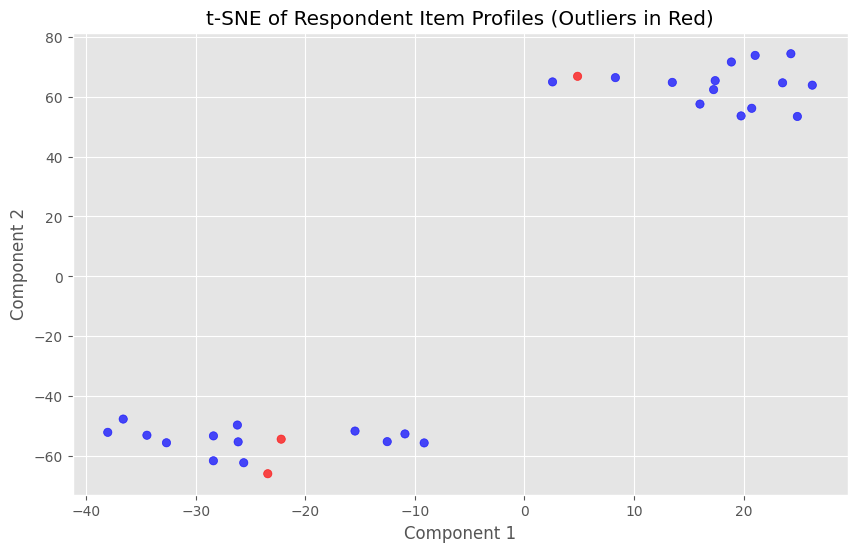

In [49]:
import matplotlib.pyplot as plt

colors = ['red' if label == 'Outlier' else 'blue' for label in responses.loc[score_df_clean.index, 'Outlier_IForest']]

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, alpha=0.7)
plt.title("t-SNE of Respondent Item Profiles (Outliers in Red)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

This plot shows how individuals group together based on their PHQ-9 and GAD-7 response patterns.  Outliers appear as red dots and typically sit on the edges or corners of clusters — meaning their full answer profile is unusual, even if their total score isn't extreme.  
This helps us detect *interesting, rare, or clinically important patterns* in the survey data.

## Step 5: Investigate the Outliers

In Step 5, we examined the three respondents flagged as outliers by Isolation Forest and found that each stood out for interesting reasons. One individual (ID 4) reported consistently high scores across both PHQ-9 and GAD-7, indicating a severe and uncommon symptom profile. Another (ID 20) showed a mismatch, with moderate depression but minimal anxiety, which is statistically unusual given the frequent co-occurrence of these conditions. Lastly, respondent 25 had mild scores on both scales, but may have been flagged due to an inconsistent or sparse answer pattern. These examples illustrate that outliers are not always extreme in total scores — they are often structurally unique in how they answered the individual survey items.

In [50]:
outliers = responses[responses['Outlier_IForest'] == 'Outlier']
outliers[['PHQ-9_Score', 'GAD-7_Score', 'PHQ-9_Bucket', 'GAD-7_Bucket']]


PHQ-9_Score  GAD-7_Score       PHQ-9_Bucket  GAD-7_Bucket
4            15           21  Moderately severe        Severe
20           14            4           Moderate  None-minimal
25            6            3               Mild  None-minimal

# Step 9: Qualitative Analysis of Natural Language

Now, let's use the the ```Add_Info``` (free-text) column to enhance our understanding of respondents — especially outliers — by identifying themes, flags, or emotional tones in their own words.

## Step 1: Preview the Data

In [51]:
responses['Add_Info'].dropna().sample(5, random_state=1)

27    I'm focused on maintaining a routine to manage...
3     I lost my job due to COVID-19. Struggling to f...
22    I sometimes think about ending it all. COVID-1...
18    I'm constantly worried about catching COVID-19...
23    Feeling really trapped that I kicked my cat. T...
Name: Add_Info, dtype: object

## Step 2: Basic Text Cleaning

We'll lowercase everything and remove extra punctuation for consistency.

In [52]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.strip()

responses['Add_Info_Clean'] = responses['Add_Info'].dropna().apply(clean_text)

## Step 3: Word Frequency or Keyword Flagging

We can count the most common words or phrases that appear in the comments. This gives a quick sense of themes.

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean and filter text
def clean_and_filter(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation
    return " ".join([word for word in text.split() if word not in stop_words])

# Apply text cleaning to Add_Info
responses['Add_Info_Filtered'] = responses['Add_Info'].dropna().apply(clean_and_filter)

# Generate word frequency counts (without stopwords)
filtered_words = " ".join(responses['Add_Info_Filtered'].dropna()).split()
filtered_counts = Counter(filtered_words)

print("Most common meaningful words:")
for word, count in filtered_counts.most_common(15):
    print(f"{word}: {count}")

Most common meaningful words:
im: 15
covid: 9
feeling: 8
health: 7
anxious: 7
pandemic: 7
feel: 7
quarantine: 6
anxiety: 6
job: 5
worried: 5
stress: 5
think: 4
future: 4
life: 4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


These themes show that many respondents are experiencing stress and anxiety, especially in relation to COVID-19 and quarantine. Words like job and future suggest concerns around economic stability and uncertainty.

## Step 4: Flag Keywords in Outliers

Let’s see what outliers said in their ```Add_Info``` column — maybe it explains their statistical anomaly.

In [59]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # to see the full text output

outliers = responses[responses['Outlier_IForest'] == 'Outlier']
outliers[['PHQ-9_Score', 'GAD-7_Score', 'PHQ-9_Bucket', 'GAD-7_Bucket', 'Add_Info']]

PHQ-9_Score  GAD-7_Score       PHQ-9_Bucket  GAD-7_Bucket  \
4            15           21  Moderately severe        Severe   
20           14            4           Moderate  None-minimal   
25            6            3               Mild  None-minimal   

                                                                                                          Add_Info  
4   The pandemic has made me feel trapped at home. I'm constantly worried about my family's health and the future.  
20                                  COVID-19 has left me feeling down and lethargic, but I'm not anxious about it.  
25                      I'm managing my stress through exercise and meditation, but the pandemic still affects me.

In reviewing the comments from the outlier respondents, we see that their open-ended responses provide a lot of important context for their unusual survey patterns!

Respondent 4 reported high depression and anxiety scores, and their comment reflects intense emotional distress linked to the pandemic and family health worries. Respondent 20, despite having a moderate depression score, explicitly stated a lack of anxiety, which explains the statistical mismatch that made them an outlier. Respondent 25, with relatively mild scores, acknowledged being affected by the pandemic despite engaging in coping strategies like exercise and meditation.

These qualitative insights align with the numerical anomalies. Indeed, we see the value of combining structured and unstructured data in mental health analysis!